In [1]:
import matplotlib.pyplot as plt
from glob import glob
import pandas as pd
import numpy as np
import sys
%matplotlib inline

In [2]:
def time_in_seconds(val):
    if "-" in val:
        fields = val.split("-")
        sec=0.0
        for i in fields:
            if "s" in i: sec += float(i.strip("s"))
            if "m" in i: sec += 60 * float(i.strip("m"))
            if "h" in i: sec += 3600 * float(i.strip("h"))
        return sec
    else:
        return float(val.strip("s"))

In [3]:
def parse_report(file_name):
    buffer = []
    resources_dict = {
        "MPI Cores": "mpi", "Threads per core": "thrs", "Threads total": "thr_tot", 
        "Nodes Computing": "nodes", "Nodes IO": "nodes_io", "MPI tasks / GPU": "mpi/gpu",
    }
    resources = {}
    timing = {}
    log = False
    with open(file_name, 'r') as report:
        for line in report:
            if line == "\n": log = False
            if log: 
                buffer.append(line.strip())
            else:
                for key, val in resources_dict.items():
                    if key in line: resources[val] = int(line.strip().split(":")[1])
                if "Time-Profile" in line:
                    timing["Time-Profile"] = time_in_seconds(line.strip().split(":")[1])

            if "Clock:" in line: log = True

    for line in buffer:
        fields = line.split(":")
        timing[fields[0].strip()] = time_in_seconds(fields[1].strip().split()[0])
    return resources, timing

In [4]:
def build_dataframe(x_axis='mpi', factor=1, rename_cols={}):
    r_files = glob("r-*")

    data = {}
    for report in r_files:
        resources, timing = parse_report(report)
        for key, val in resources.items():
            if key in data:
                data[key].append(val)
            else:
                data[key] = [val,]
        for key, val in timing.items():
            if key in data:
                data[key].append(val)
            else:
                data[key] = [val,]
    
    scaling = pd.DataFrame(data)
    if rename_cols: 
        scaling.rename(columns=rename_cols, inplace=True)
    else:
        scaling.rename(columns={'Xo (procedure)': 'Xo', 'X (procedure)': 'X'}, inplace=True)
    scaling.sort_values(by=[x_axis], inplace=True)
    if 'mpi/gpu' in scaling: scaling['gpu'] = pd.Series(scaling['mpi'] / scaling['mpi/gpu'], dtype=np.int64)
    scaling['ideal'] = scaling[x_axis] / factor
    scaling['speedup'] = scaling[scaling[x_axis]>=factor]['Time-Profile'].max() / scaling['Time-Profile']
    scaling['efficiency'] = scaling.speedup / scaling.ideal * 100
    scaling['Self energy'] = scaling['HF'] + scaling['GW(ppa)']
    scaling['Other'] = scaling['Time-Profile'] - scaling['Dipoles'] - scaling['Xo'] - scaling['X'] - scaling['Self energy']
    scaling['node_h'] = scaling['nodes'] * scaling['Time-Profile'] / 3600
    return scaling

In [6]:
def build_scaling_plot(scaling, pile, colors, x_axis='mpi', x_label='MPI tasks', bar_width=1,
                       title=None, legend_loc=None, label=None, label_pos=None, efficiency=True, 
                       file_name='scaling.png', y_lim=None):
    if len(pile) != len(colors):
        sys.stderr.write("Error: the number of elements of pile and colors lists have to be the same.")
        return
    fig, ax1 = plt.subplots(figsize=(10, 7))

    bottom = pd.Series(dtype='float64')
    for key, color in zip(pile, colors):
        if bottom.empty:
            ax1.bar(scaling[x_axis], scaling[key], width=bar_width, color=color, label=key)
            bottom = scaling[key].copy()
        else:
            ax1.bar(scaling[x_axis], scaling[key], width=bar_width, color=color, label=key, bottom=bottom)
            bottom += scaling[key]

    ax1.set_xlabel(x_label,fontsize=20)
    ax1.set_ylabel('Time (sec)',fontsize=20)
    ax1.legend()
    if y_lim: ax1.set_ylim(y_lim)
    if legend_loc: ax1.legend(fontsize='18',framealpha=0.0, loc=legend_loc)
    ax1.tick_params(axis = 'both', which = 'major', labelsize = 18)
    if label and label_pos: ax1.text(*label_pos, label, fontsize=20)
    plt.xticks(scaling[x_axis])
    
    if efficiency:
        ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
        ax2.set_ylim([-10, 110])
        ax2.set_ylabel('Efficiency (%)', color='tab:blue',fontsize=20)  # we already handled the x-label with ax1
        ax2.plot(scaling[x_axis], scaling['efficiency'], linewidth=3, color='tab:blue')
        ax2.tick_params(axis='y', labelcolor='tab:blue', labelsize=18)
        fig.tight_layout()  # otherwise the right y-label is slightly clipped
    
    if title: plt.title(title, fontsize=20)
    plt.savefig(file_name, bbox_inches='tight')

In [7]:
def build_cost_plot(scaling, label='yambo', title=None, y_lim=None, file_name='cost.pdf'):
    fig2, ax3 = plt.subplots(figsize=(10, 7))
    ax3.set_xlabel('Time to solution (sec)',fontsize=20)
    ax3.set_ylabel('Cost (node*hour)',fontsize=20)
    ax3.plot(scaling['Time-Profile'], scaling['node_h'], 
             linewidth=3, color=colors[0], marker='.', markersize=15,
             label=label)
    if y_lim: ax3.set_ylim(y_lim)
    ax3.legend()
    ax3.legend(fontsize='18',framealpha=0.0)

    if title: plt.title(title, fontsize=20)
    plt.savefig(file_name)

In [9]:
scaling = build_dataframe(x_axis='mpi', factor=12)
scaling.to_csv('scaling.csv', sep='\t')
scaling

mpi  thrs  thr_tot  nodes  nodes_io  mpi/gpu  Time-Profile  \
2    4     8       32      1         1        1        2861.0   
9   12     8       96      3         1        1         798.0   
7   16     8      128      4         1        1         654.0   
3   36     8      288      9         1        1         256.0   
0   64     8      512     16         1        1         171.0   
4   72     8      576     18         1        1         154.0   
6  108     8      864     27         1        1         114.0   
8  144     8     1152     36         1        1         101.0   
1  180     8     1440     45         1        1          91.0   
5  216     8     1728     54         1        1          91.0   

   io_ATMPROJ_pwscf  io_KB_abinit   io_BS  ...  DIPOLE_transverse  Dipoles  \
2            0.0001        0.0001  0.0002  ...            87.6268  89.4712   
9            0.0001        0.0001  0.0002  ...            33.4803  35.8163   
7            0.0001        0.0001  0.0002  ...            58.4488  62.2383   
3            0.0002        0.0001  0.0003  ...            15.1305  17.9305   
0            0.0001        0.0002  0.0004  ...            11.9937  15.0317   
4            0.0001        0.0001  0.0003  ...            10.5790  14.3519   
6            0.0001        0.0002  0.0003  ...             8.7874  12.4867   
8            0.0002        0.0002  0.0003  ...             9.3590  14.2410   
1            0.0003        0.0003  0.0005  ...             9.1727  15.1135   
5            0.0003        0.0002  0.0007  ...             8.5242  13.5992   

          Xo  gpu      ideal   speedup  efficiency  Self energy    Other  \
2  2742.0000    4   0.333333  0.278923   83.677036      16.7167  10.8669   
9   737.0000   12   1.000000  1.000000  100.000000       9.0889  13.7543   
7   517.8356   16   1.333333  1.220183   91.513761      25.8271  32.3344   
3   220.4115   36   3.000000  3.117188  103.906250       4.6583  10.6562   
0   139.6190   64   5.333333  4.666667   87.500000       3.7390  10.1865   
4   123.9023   72   6.000000  5.181818   86.363636       3.3195  10.8713   
6    85.5235  108   9.000000  7.000000   77.777778       1.8856  11.9543   
8    68.8225  144  12.000000  7.900990   65.841584       1.7019  14.0067   
1    59.3384  180  15.000000  8.769231   58.461538       1.5501  13.3188   
5    50.6671  216  18.000000  8.769231   48.717949       1.6663  22.1815   

     node_h  
2  0.794722  
9  0.665000  
7  0.726667  
3  0.640000  
0  0.760000  
4  0.770000  
6  0.855000  
8  1.010000  
1  1.137500  
5  1.365000  

[10 rows x 52 columns]

In [10]:
colors=['#2EA6A6', '#F28F38', '#47AB6C', '#112F41', '#D90718']
pile = ['Dipoles', 'Xo', 'X', 'Self energy', 'Other']
scaling[['mpi', 'Time-Profile'] + pile]

mpi  Time-Profile  Dipoles         Xo        X  Self energy    Other
2    4        2861.0  89.4712  2742.0000   1.9452      16.7167  10.8669
9   12         798.0  35.8163   737.0000   2.3405       9.0889  13.7543
7   16         654.0  62.2383   517.8356  15.7646      25.8271  32.3344
3   36         256.0  17.9305   220.4115   2.3435       4.6583  10.6562
0   64         171.0  15.0317   139.6190   2.4238       3.7390  10.1865
4   72         154.0  14.3519   123.9023   1.5550       3.3195  10.8713
6  108         114.0  12.4867    85.5235   2.1499       1.8856  11.9543
8  144         101.0  14.2410    68.8225   2.2279       1.7019  14.0067
1  180          91.0  15.1135    59.3384   1.6792       1.5501  13.3188
5  216          91.0  13.5992    50.6671   2.8859       1.6663  22.1815

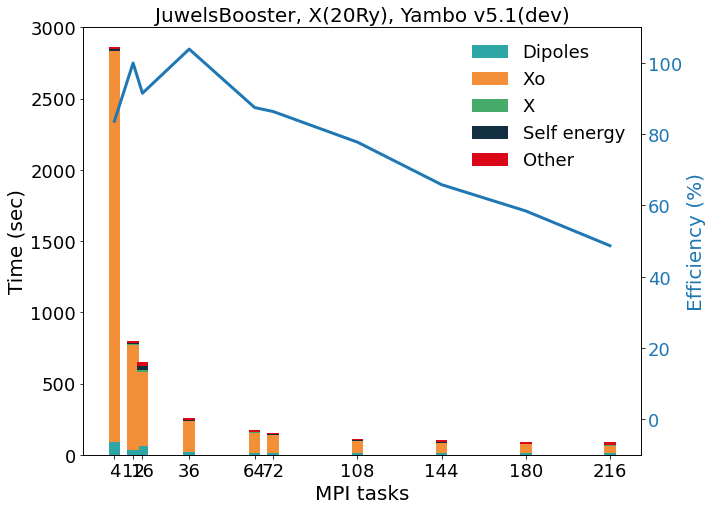

In [15]:
#[(scaling['mpi']==4) | (scaling['mpi']>36)]
build_scaling_plot(scaling=scaling, 
                   pile=pile, colors=colors, bar_width=5, efficiency=True,
                   legend_loc='upper right', title=r'JuwelsBooster, X(20Ry), Yambo v5.1(dev)', 
                   file_name='scaling_1nodes.png', y_lim=[0,3000])

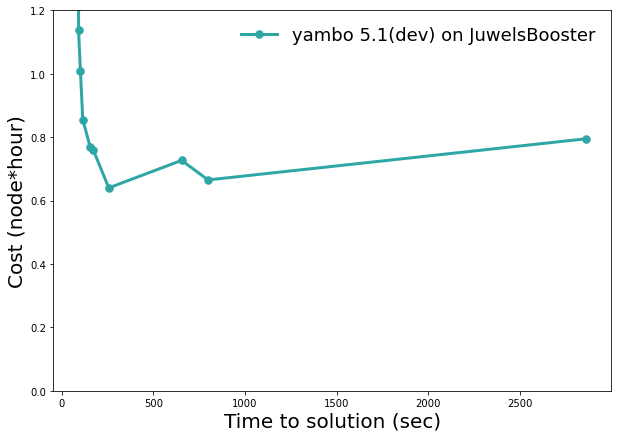

In [16]:
build_cost_plot(scaling=scaling, label='yambo 5.1(dev) on JuwelsBooster', y_lim=[0,1.2])

In [10]:
def build_speedup_plot(scaling, label='yambo', title=None, y_lim=None, x_axis='mpi', file_name='speedup.png'):
    fig, ax = plt.subplots(figsize=(10, 7))
    if x_axis=='mpi':
        xlabel = 'MPI tasks'
    elif x_axis=='nodes':
        xlabel = 'Nodes'
    else:
        xlabel = x_axis
    ax.set_xlabel(xlabel,fontsize=20)
    ax.set_ylabel('Speedup',fontsize=20)
    ax.plot(scaling[x_axis], scaling['ideal'], 
             linewidth=3, color='black', marker='.', markersize=15,
             label='ideal')
    ax.plot(scaling[x_axis], scaling['speedup'], 
             linewidth=3, color=colors[0], marker='.', markersize=15,
             label=label)
    if y_lim: ax.set_ylim(y_lim)
    ax.legend()
    ax.legend(fontsize='18',framealpha=0.0)
    ax.tick_params(axis = 'both', which = 'major', labelsize = 18)
    plt.xticks(scaling[x_axis])
    if title: plt.title(title, fontsize=20)
    plt.savefig(file_name, bbox_inches='tight')

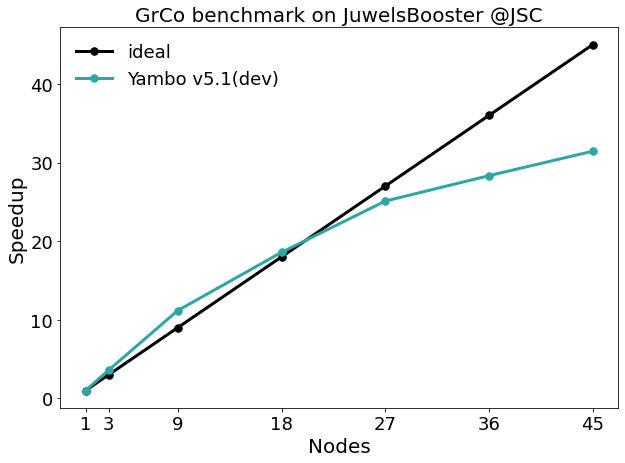

In [11]:
s=True;n=False
#                 1  3  4  9  16 18 27 36 45 54  
filtro=pd.Series((s, s, n, s, n, s, s, s, s, n), index=scaling.mpi.index)
build_speedup_plot(scaling=scaling[filtro], title=r'GrCo benchmark on JuwelsBooster @JSC', label=r'Yambo v5.1(dev)', x_axis='nodes')

In [12]:
condition = (scaling['nodes']!=1) & (scaling['nodes']!=4) & (scaling['nodes']!=16) & (scaling['nodes']!=54)
scaling[condition][['mpi', 'nodes', 'Time-Profile'] + pile].to_csv('strong_scaling.csv', sep='\t', index=False)

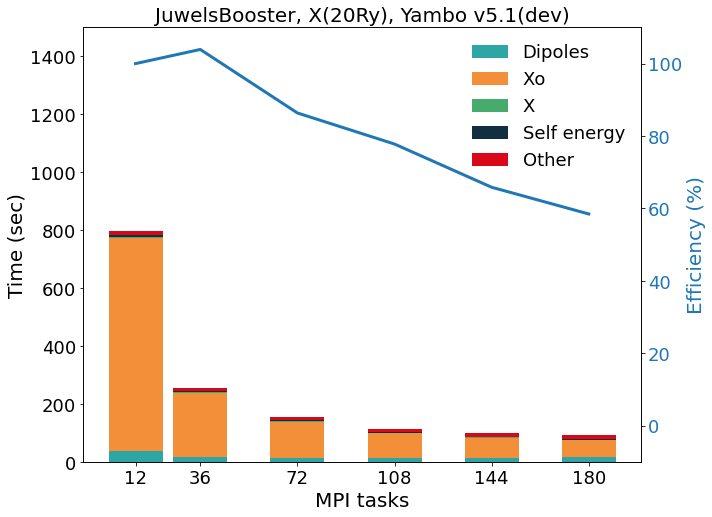

In [17]:
build_scaling_plot(scaling=scaling[condition], 
                   pile=pile, colors=colors, bar_width=20, efficiency=True,
                   legend_loc='upper right', title=r'JuwelsBooster, X(20Ry), Yambo v5.1(dev)', 
                   file_name='scaling_3nodes.png', y_lim=[0,1500])